# Powerlifting Data Visualization

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import pytz
import datetime

## Scale factors
Constants used to project 1RM (one rep max) for different rep ranges from 1-10

In [118]:
scale_factors = {1:1,2:.96,3:.92,4:.89,5:.87,6:.84,7:.81,8:.79,9:.76,10:.74}

In [119]:
df = pd.read_csv('../data/WorkoutExport.csv')

## Filtering dataset

In [120]:
df = df[df['isWarmup'] == False] # Remove warm-up sets
df = df[(df['Reps'] < 11) & (df['Reps'] > 0)] # Keep only data with reps 1-10
df['Weight(lbs)'] = df['Weight(kg)'] * 2.20462 # Convert weight to lbs

# Add a column to dataframe containing projected 1RM for each row in data
scale_columns = [scale_factors[reps] for reps in df['Reps']] 
df['1RM'] = df['Weight(lbs)']/scale_columns

# Convert Date column to datetime
dates = []
unix_dates = []
for d in df['Date']:
    date_obj = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S %z')
    dates.append(date_obj)
    unix_date = time.mktime(date_obj.timetuple())
    unix_dates.append(unix_date)
df['Date'] = dates
df['Unix_Date'] = unix_dates

df = df[['Unix_Date', 'Date', 'Exercise', 'Reps', 'Weight(lbs)', '1RM']] # Select only relevant columns
# print(df.to_string())

In [121]:
# Keep only rows with highest 1RM for each exercise for each date
grouped = df.groupby(by = ['Date','Exercise'])
df = df[df['1RM'] == (grouped.transform('max')['1RM'])]
df = df.drop_duplicates()

# Create dataframes for each exercise

In [122]:
df_squat = df[(df['Exercise'] == 'Back Squat') & (df['Weight(lbs)'] > 186)] # remove additional warm-up sets
# print(df_squat.to_string())
df_bench = df[df['Exercise'] == 'Barbell Bench Press']
# print(df_bench.to_string())
df_deadlift = df[(df['Exercise'] == 'Deadlift') & (df['Weight(lbs)'] > 186)] # remove additional warm-up sets
# print(df_deadlift.to_string())
df_sumo_deadlift = df[(df['Exercise'] == 'Sumo Deadlift') & (df['Weight(lbs)'] > 186)] # remove additional warm-up sets
# print(df_sumo_deadlift.to_string())

## Visualizing data with matplotlib

Text(0.5, 0, 'Date')

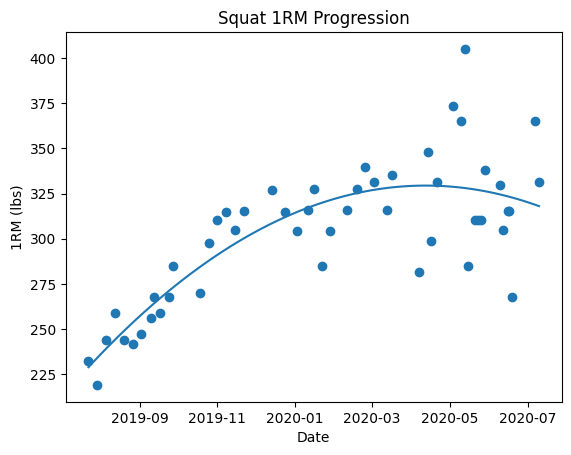

In [123]:
# fit quadratic regression model to squat data

plt.scatter(df_squat['Date'], df_squat['1RM'])
x2, x1, b = np.polyfit(df_squat['Unix_Date'], df_squat['1RM'], 2)
x = np.linspace(df_squat['Unix_Date'].min(), df_squat['Unix_Date'].max(), 100)
reg_line = x2 * (x ** 2) + x1 * x + b
x = [datetime.datetime.fromtimestamp(d, pytz.timezone('UTC')) for d in x]
plt.plot(x, reg_line)
plt.title('Squat 1RM Progression')
plt.ylabel('1RM (lbs)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

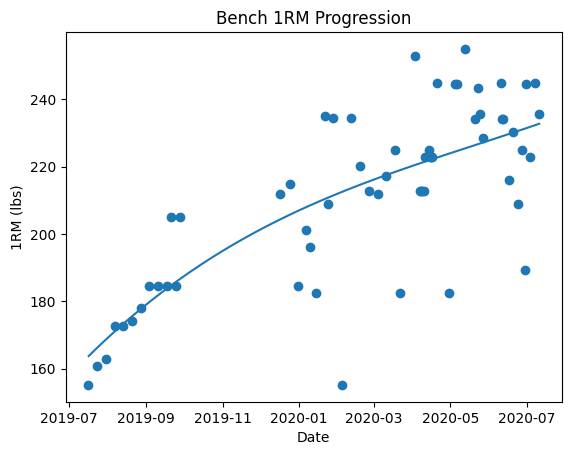

In [124]:
# fit cubic regression model to bench data

plt.scatter(df_bench['Date'], df_bench['1RM'])
x3, x2, x1, b = np.polyfit(df_bench['Unix_Date'], df_bench['1RM'], 3)
x = np.linspace(df_bench['Unix_Date'].min(), df_bench['Unix_Date'].max(), 100)
reg_line = x3 * (x ** 3) + x2 * (x ** 2) + x1 * x + b
x = [datetime.datetime.fromtimestamp(d, pytz.timezone('UTC')) for d in x]
plt.plot(x, reg_line)
plt.title('Bench 1RM Progression')
plt.ylabel('1RM (lbs)')
plt.xlabel('Date')

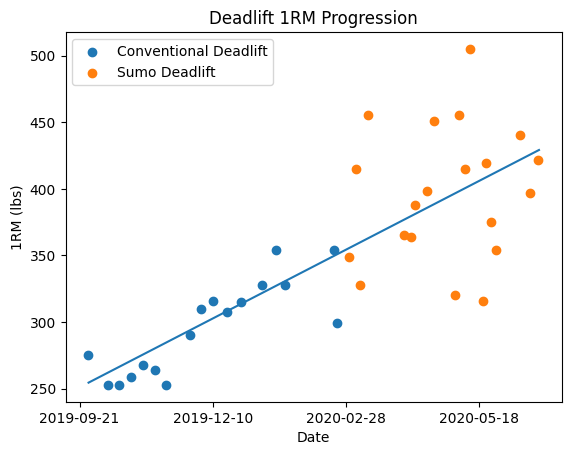

In [125]:
# fit linear regression model to deadlift data

fig, ax = plt.subplots()
plt.scatter(df_deadlift['Date'], df_deadlift['1RM'], label='Conventional Deadlift')
plt.scatter(df_sumo_deadlift['Date'], df_sumo_deadlift['1RM'], label='Sumo Deadlift')

df_all_deadlifts = pd.concat([df_deadlift, df_sumo_deadlift])
x1, b = np.polyfit(df_all_deadlifts['Unix_Date'], df_all_deadlifts['1RM'], 1)
x = np.linspace(df_all_deadlifts['Unix_Date'].min(), df_all_deadlifts['Unix_Date'].max(), 100)
reg_line = x1 * x + b
x = [datetime.datetime.fromtimestamp(d, pytz.timezone('UTC')) for d in x]
plt.plot(x, reg_line)

plt.title('Deadlift 1RM Progression')
plt.ylabel('1RM (lbs)')
plt.xlabel('Date')
plt.legend()
ax.xaxis.set_major_locator(plt.MaxNLocator(4))